# YOLO model




## 1.   Pronalazak i pretprocesiranje dataset-a




  *   Dataset sadrži 7000 slika sa izračunatim bounding boxovima
  *   Struktura dataset-a



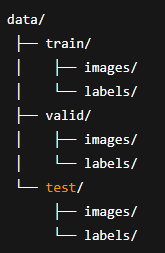






*   Trebamo proći kroz dataset, "upoznati" se sa strukturom, videti tačnost bounding boxova, kvalitet slika, broj duplikata
*   Različiti datset-ovi su drugačije struktuirani, potrebno je napisati skriptu za kovnertovanje dataseta u struktura koja odgovara našim potrebama
*   Za YOLO model potrebna je sledeća struktura







<#class_id> <#x_center> <#y_center> <#width> <#height>

In [ ]:
!python src/yolo/preprocessing/convert.py



*   Posle konvertovanja dobijamo sledeću strukturu koja je pogodna za treniranje YOLO modela
*   Takođe je potreban data.yaml



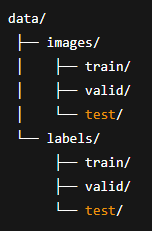



```
# data.yaml

path: data/yolo/processedV2
train: images/train
val: images/valid
test: images/test

nc: 1
names:
  0: food
```





## 2.   Treniranje modela




*   Potrebno instalirati biblioteku "ultralytics" i pokrenuti *code* sekciju za trenrianje model
*   NAPOMENA


```
    CUDA radi samo na NVIDIA GPU
    ROCm (AMD ekvivalent) radi samo na Linuxu, ne na Windowsu
    Ako koristite windows i imate AMD GPU prepourka je korišćenje free tier na google colab
```





In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

    # Start training
model.train(
        data="data.yml",
        epochs=100,
        imgsz=512,
        batch=16,
        device=0,
        augment=True,
        degrees=5,
        translate=0.05,
        scale=0.1
    )

## 3. Testiranje i metrike modela



*   Učitati sačuvani model i pokrenuti *code* sekciju



In [ ]:
metrics = model.val(data="data.yml", split="test")

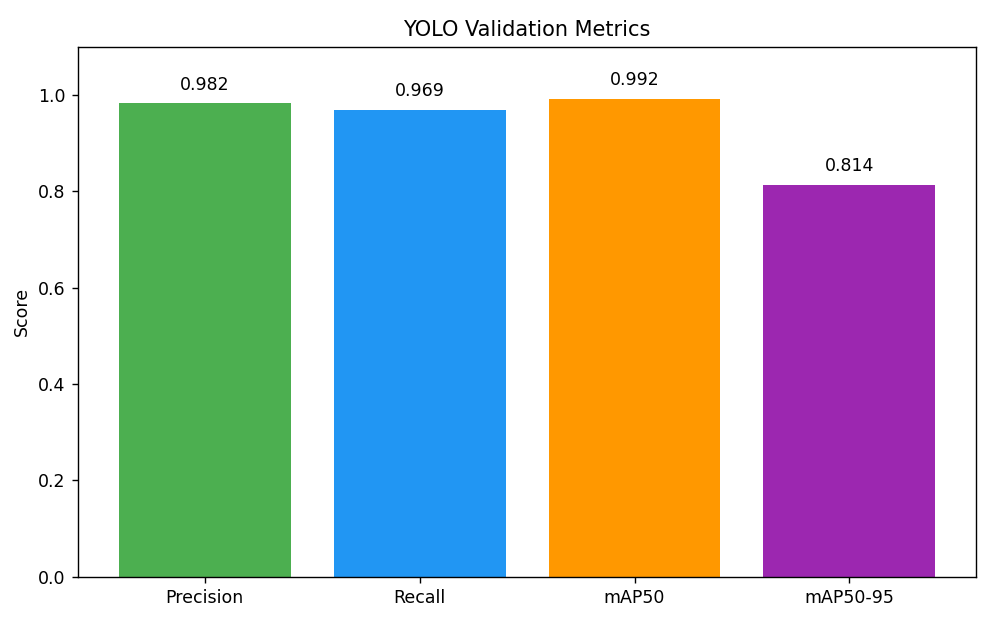

**Rezultat metrike**



*   precision - ≥ 0.80 (vrlo dobro), 0.90+ odlično - „Koliko su tačne detekcije koje je model napravio?“
*   Recall - ≥ 0.70 (vrlo dobro), 0.85+ odlično - Koliki procenat stvarnih objekata je pronađen.
*   mAP@0.50 - ≥ 0.50 (prihvatljivo), 0.70+ dobro, 0.85+ vrhunsko - Prosečna preciznost pri toleranciji da se box i ground truth preklapaju barem 50%.
*   mAP@0.50:0.95 - ≥ 0.30 (prihvatljivo), 0.50+ dobro, 0.60+ vrhunsko - Striktnija provera od mAP@0.50


# CNN model



## 1.   Pretprocesiranje dataset-a





*   Dataset sadrži 15000 slika
*   Struktura dataset-a



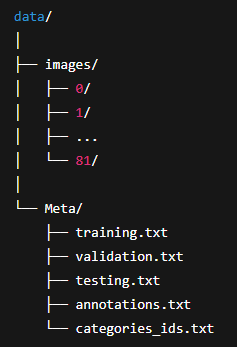



*   Images folder sadrži podfoldere u opsegu [0,81], brojevi predstavljaju klase hrane. U svakom podfolderu su nizovi slika u .jpg formatu
*   Meta folder sadrži podelu na training, validation i testing skup slike kao i category_ids.txt fajl koji mapira brojeve foldera na stvarno ime hrane




*   Kako bismo željenu strukturu za treniranje CNN modela potrebno nam je pretprocesiranje dataset-a



In [ ]:
!python src/cnn/preprocess.py

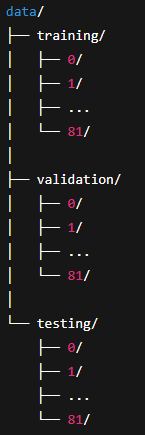

## 2. Treniranje modela

Za treniranje CNN (konvolucionih neuronskih mreža) koristimo pretreniran model ResNet-18



```
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
```





*   Učitivamo training i validation foldere sa slikama u .jpg formatu
*   Učitivamo pretirani CNN ResNet-18 model
*   Pronalazimo odgovarajući optimizer i learning rate koja najbolje odgovara našem modelu i datasetu
*  Koristimo Adam optimezer i learning rate=1e-4
* Emprijiski postavljamo broj epoha i posle svake epohe proveravamo metrike modela, ako dobijemo bolje metrike od prethodnog modela, čuvamo novi model



In [ ]:
!python src/cnn/train_resnet.py

## 3. Testiranje i metrike modela



*   Učitamo test skup i istrenirani CNN model
*   Pokrenemo evaluaciju i vidimo metriku modela



In [ ]:
!python src/cnn/test_resnet.py

Koristimo tačnost kao metriku, vrednost u rasponu 0% i 100%

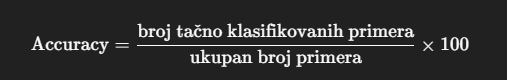

Dobijena tačnost je 63.52%


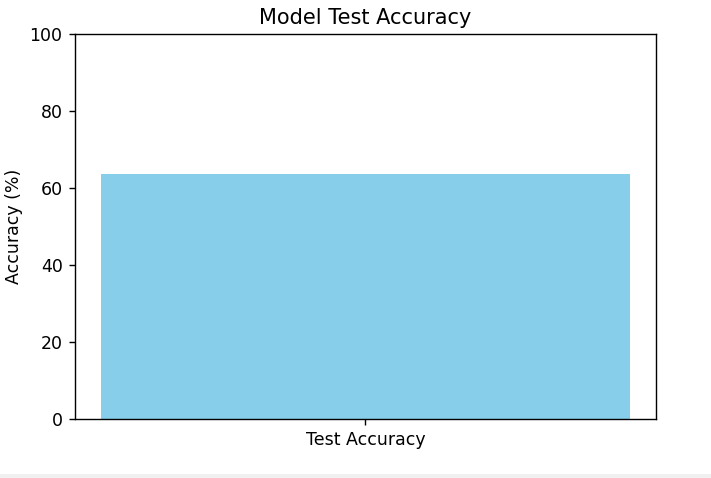

# Detekcija i klasifikacija

## Pronalazak hrane na slici pomoću istreniranog YOLO modela



*   Učitavamo sliku i puštamo je kroz YOLO model da nam detektuje hranu na slici



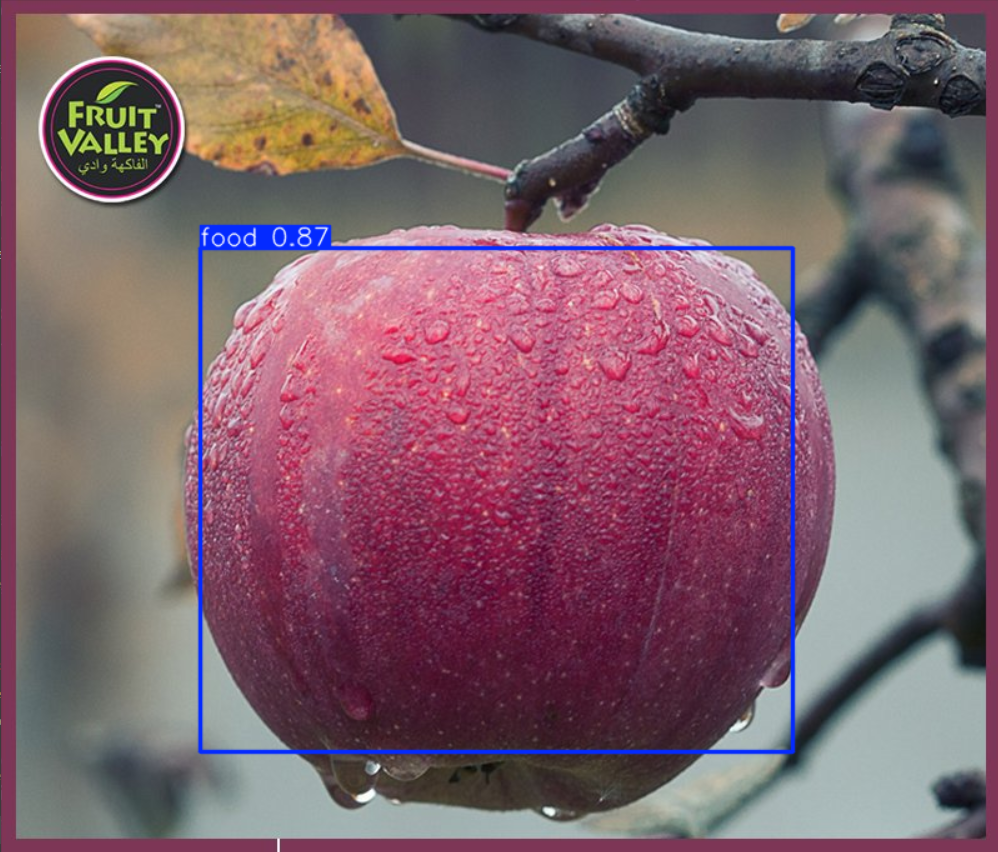

## Klasifikacija vrste hrane pomoću CNN modela na osnovu slike koju je YOLO model izrezao (crop image)



*   Dobijenu sliku istrenirani CNN model klasifikuje u klasu



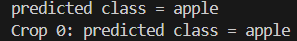